In [1]:
#pip install scikit-learn
#pip install pandas

# Main imports pandas and sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# We may need to do some web scraping to get the review text
import urllib.request
from bs4 import BeautifulSoup

#Other imports
import time
import sys
from os import system
from IPython.display import clear_output

# Load in data
### There are a few steps to getting clean data
- Read data from kaggle into dataframes
- Get rid of unecessary features of the data
- (For game spot data) get the review text from the web
- Clean data using dropna

## Read in data from csv

In [2]:
# download dataset at: https://www.kaggle.com/datasets/joyshil0599/multi-decade-video-game-review-dataset
GAME_SPOT_DATASET_PATH = "data/game_spot_data.csv"
# downoad dataset at: https://www.kaggle.com/datasets/andrewmvd/steam-reviews
STEAM_DATASET_PATH = 'data/steam_data.csv'
# download dataset at: https://www.kaggle.com/datasets/noahx1/elden-ring-steam-reviews
ELDEN_RING_DATASET_PATH = "data/elden_ring_data.csv"

# Read in the datasets
game_spot_data = pd.read_csv(GAME_SPOT_DATASET_PATH)
steam_data = pd.read_csv(STEAM_DATASET_PATH)
elden_ring_data = pd.read_csv(ELDEN_RING_DATASET_PATH)

In [3]:
# Lets only keep the columns we want
game_spot_cols = ['Review link','Rating/10']
if('Review' in game_spot_data.columns):
    game_spot_cols.append('Review')
steam_cols = ['review_text','review_score']
elden_ring_cols = ['voted_up','review']

game_spot_data = game_spot_data[game_spot_cols]
steam_data = steam_data[steam_cols]
elden_ring_data = elden_ring_data[elden_ring_cols]

# Lets rename some columns and change them to be consistant
steam_data['review_score'].replace({1:True,-1:False},inplace=True)
steam_data.rename(columns={'review_score':'up_vote','review_text':'Review'}, inplace=True)
elden_ring_data.rename(columns={'voted_up':'up_vote','review':'Review'},inplace=True)

# Read in reviews from web (for game spot data)

In [4]:
# Now lets define how to get the text of the reviews from the web
def GetReviewsFromWeb():
    num_processed = 1
    prev_time = time.time()
    num_links = len(game_spot_data.index)
    check_interval = 5
    reviews = []
    failed_links = []
    for link in game_spot_data['Review link']:
        # Try to get the review text
        try:
            page = urllib.request.urlopen(link).read()
            page = BeautifulSoup(page)
            review = ""
            body = page.find(class_="article-body typography-format")
            paragraphs = body.find_all("p")
            if(len(paragraphs)==0):
                raise Exception('NO REVIEW TEXT FOUND')
            for p in paragraphs:
                review+=p.text+" "
            reviews.append(review)
        # If we could not get the review text
        except:
            reviews.append(None)
            failed_links.append(link)
        # Display progress
        num_processed = num_processed + 1
        if(num_processed % check_interval == 0):
            prediction = (time.time() - prev_time)/(check_interval) * (num_links-len(reviews))
            prev_time = time.time()
            system('cls')
            clear_output(wait=True)
            print(f"Reviews lost: {len(failed_links)}")
            print(f"processed: {num_processed} / {num_links}")
            print(f"Time left: {int(prediction)} s")  
    # Update dataframe and write to file
    game_spot_data['Review'] = reviews
    

In [5]:
# If gamespot data does not have review then we need to get it from the web
if(not 'Review' in game_spot_data.columns):
    GetReviewsFromWeb()
    game_spot_data.to_csv(GAME_SPOT_DATASET_PATH, index=False)

# Now lets define our classifications (Sentiment)

In [6]:
# We define 2 sentiments to classify
GOOD = 'Good'
BAD = 'Bad'

In [7]:
def GetSentimentFromRating(rating):
    if(rating is None):
        return None
    if(rating > 7):
        return GOOD
    if(rating > 0):
        return BAD

In [8]:
def GetSentimentFromUpVote(up_vote):
    if(up_vote):
        return GOOD
    else:
        return BAD

In [9]:
def AddSentiment(df):
    s = []
    if('Rating/10' in df.columns):
        for rating in game_spot_data['Rating/10'].to_list():
            s.append(GetSentimentFromRating(rating))
    elif('up_vote' in df.columns):
        for upvote in df['up_vote'].to_list():
            s.append(GetSentimentFromUpVote(upvote))
    else:
        raise Exception(f"No column in dataframe to use for sentiment! {df.columns}")
    df['Sentiment'] = s
    print("DATA DISTRIBUTION:")
    SENTIMENTS = df['Sentiment'].unique()
    for s in SENTIMENTS:
        print(f"{s}: {sum(1 for i in df['Sentiment'] if i == s)}")

In [10]:
AddSentiment(game_spot_data)
AddSentiment(steam_data)
AddSentiment(elden_ring_data)

DATA DISTRIBUTION:
Bad: 6743
Good: 5823
DATA DISTRIBUTION:
Good: 5260420
Bad: 1156686
DATA DISTRIBUTION:
Good: 9201
Bad: 593


# Clean data

In [11]:
def CleanData(df):
    # Now lets finish cleaning the data by dropping any invalid rows
    old_size = df.shape
    df.dropna(inplace=True)
    new_size = df.shape
    print("Dropping rows")
    print(f"Old count: {old_size[0]}")
    print(f"New count: {new_size[0]}")
    print(f"Removed {old_size[0]-new_size[0]} rows.")
    

In [12]:
CleanData(game_spot_data)
CleanData(steam_data)
CleanData(elden_ring_data)

Dropping rows
Old count: 12566
New count: 12566
Removed 0 rows.
Dropping rows
Old count: 6417106
New count: 6409801
Removed 7305 rows.
Dropping rows
Old count: 9794
New count: 9765
Removed 29 rows.


# Now we split our data

In [13]:
def SplitData(df,test_split=0.3):
    #split datasets
    X = df['Review']
    y = df['Sentiment'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state=1) 
    X_train.to_list()
    X_test = X_test.to_list()
    y_train = y_train.to_list()
    y_test = y_test.to_list()
    return X_train, X_test, y_train, y_test 

In [14]:
game_spot_X_train, game_spot_X_test, game_spot_y_train, game_spot_y_test = SplitData(game_spot_data)
steam_X_train, steam_X_test, steam_y_train, steam_y_test = SplitData(steam_data)
elden_ring_X_train, elden_ring_X_test, elden_ring_y_train, elden_ring_y_test = SplitData(elden_ring_data)

## Vectorize the data
We will be using a method called **Term Frequency and Inverse Document Frequency (TF-IDF)**. 
Here is how it works: https://medium.com/@vasista/preparing-the-text-data-with-scikit-learn-b31a3df567e

#### sklearn supplies an easy way to implement this

In [15]:
def CreateVectorizer(X_train):
    vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True)
    train_vectors = vectorizer.fit_transform(X_train)
    return vectorizer, train_vectors

# Creating svm
#### Helpful link to understand how this works:
- https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1



In [16]:
def TestSVM(svm_linear, vectorizer, X_test, y_test): 
    print('Testing SVM ...')
    start_time = time.time()
    test_vectors = vectorizer.transform(X_test)
    prediction = svm_linear.predict(test_vectors)
    end_time = time.time()
    print(f"Tested SVM in {end_time-start_time} s")
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, prediction)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = svm_linear.classes_)
    cm_disp.plot()
    for key in report.keys():
        print(f'{key}: {report[key]}\n')
    return report

In [17]:
def CreateSVM(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizer(x_train)
    svm_linear = svm.LinearSVC()
    start_time = time.time()
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer

# Train SVM with game spot data

In [18]:
game_spot_svm, game_spot_vectorizer = CreateSVM(game_spot_X_train, game_spot_y_train)

training SVM...
Trained SVM in 0.36486101150512695 s


### Test game_spot_svm on game_spot test data

Testing SVM ...
Tested SVM in 3.5069119930267334 s
Bad: {'precision': 0.8576423576423576, 'recall': 0.85, 'f1-score': 0.8538040775733465, 'support': 2020}

Good: {'precision': 0.8286199095022625, 'recall': 0.8371428571428572, 'f1-score': 0.8328595793064241, 'support': 1750}

accuracy: 0.8440318302387267

macro avg: {'precision': 0.8431311335723101, 'recall': 0.8435714285714286, 'f1-score': 0.8433318284398853, 'support': 3770}

weighted avg: {'precision': 0.844170398956637, 'recall': 0.8440318302387267, 'f1-score': 0.8440818303672154, 'support': 3770}



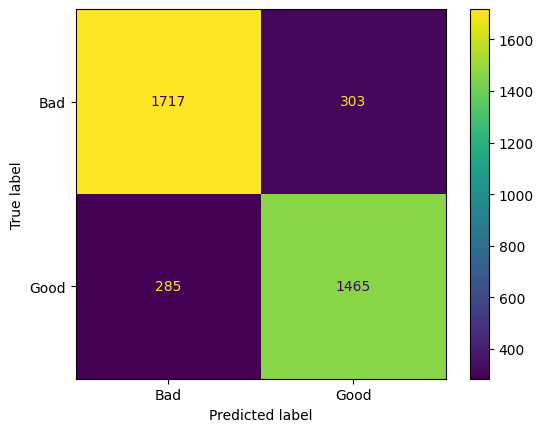

In [20]:
report = TestSVM(game_spot_svm, game_spot_vectorizer, game_spot_X_test, game_spot_y_test)

### Test game_spot_svm on steam data

Testing SVM ...
Tested SVM in 84.9576199054718 s
Bad: {'precision': 0.20026498373433543, 'recall': 0.9904977714737103, 'f1-score': 0.3331679954306616, 'support': 346866}

Good: {'precision': 0.9841052448833935, 'recall': 0.1294786098377298, 'f1-score': 0.22884774864741658, 'support': 1576075}

accuracy: 0.28479188909072095

macro avg: {'precision': 0.5921851143088644, 'recall': 0.55998819065572, 'f1-score': 0.2810078720390391, 'support': 1922941}

weighted avg: {'precision': 0.8427137325989661, 'recall': 0.28479188909072095, 'f1-score': 0.2476653549706044, 'support': 1922941}



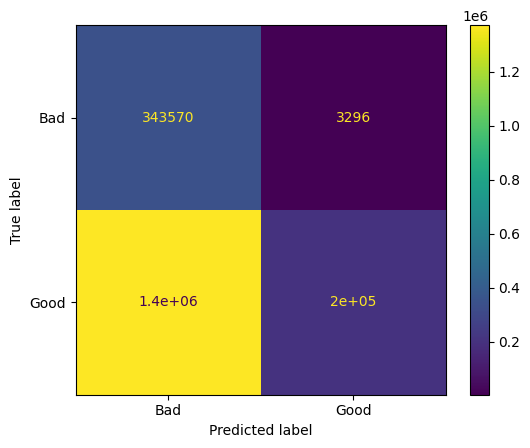

In [22]:
report = TestSVM(game_spot_svm, game_spot_vectorizer, steam_X_test, steam_y_test)

### Test game_spot_svm on elden ring data

Testing SVM ...
Tested SVM in 0.07402849197387695 s
Bad: {'precision': 0.0652256351915055, 'recall': 0.9885057471264368, 'f1-score': 0.12237637851298469, 'support': 174}

Good: {'precision': 0.9931740614334471, 'recall': 0.1055878084179971, 'f1-score': 0.1908822564775336, 'support': 2756}

accuracy: 0.15802047781569967

macro avg: {'precision': 0.5291998483124764, 'recall': 0.547046777772217, 'f1-score': 0.15662931749525916, 'support': 2930}

weighted avg: {'precision': 0.9380672265644717, 'recall': 0.15802047781569967, 'f1-score': 0.18681398932195972, 'support': 2930}



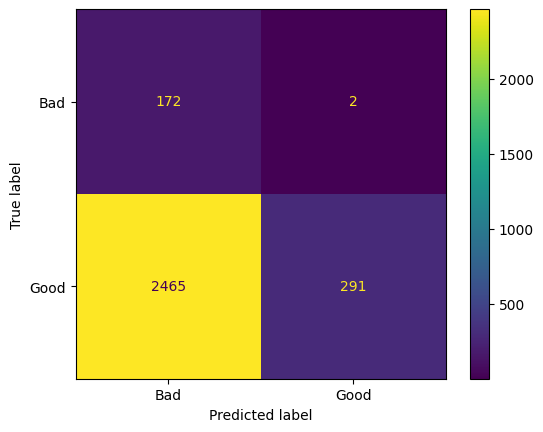

In [23]:
report = TestSVM(game_spot_svm, game_spot_vectorizer, elden_ring_X_test, elden_ring_y_test)

# Train SVM with elden ring data

In [29]:
elden_ring_svm, elden_ring_vectorizer = CreateSVM(elden_ring_X_train, elden_ring_y_train)

training SVM...
Trained SVM in 0.017498254776000977 s


### Test elden_ring_svm on elden ring test data

Testing SVM ...
Tested SVM in 0.05907273292541504 s
Bad: {'precision': 0.7142857142857143, 'recall': 0.3448275862068966, 'f1-score': 0.46511627906976755, 'support': 174}

Good: {'precision': 0.9599437807449052, 'recall': 0.9912917271407837, 'f1-score': 0.9753659407354516, 'support': 2756}

accuracy: 0.952901023890785

macro avg: {'precision': 0.8371147475153098, 'recall': 0.6680596566738402, 'f1-score': 0.7202411099026096, 'support': 2930}

weighted avg: {'precision': 0.9453552129756563, 'recall': 0.952901023890785, 'f1-score': 0.9450644249914826, 'support': 2930}



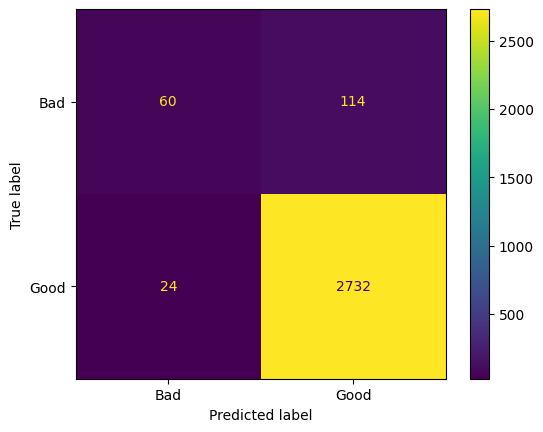

In [30]:
report = TestSVM(elden_ring_svm, elden_ring_vectorizer, elden_ring_X_test, elden_ring_y_test)

### Test elden_ring_svm on steam data

Testing SVM ...
Tested SVM in 72.98530340194702 s
Bad: {'precision': 0.7053500439385697, 'recall': 0.19437765592476633, 'f1-score': 0.3047684053031502, 'support': 346866}

Good: {'precision': 0.8470777129542021, 'recall': 0.982129657535333, 'f1-score': 0.9096181849593997, 'support': 1576075}

accuracy: 0.8400325334994677

macro avg: {'precision': 0.7762138784463859, 'recall': 0.5882536567300497, 'f1-score': 0.607193295131275, 'support': 1922941}

weighted avg: {'precision': 0.8215124409875758, 'recall': 0.8400325334994677, 'f1-score': 0.800513525133516, 'support': 1922941}



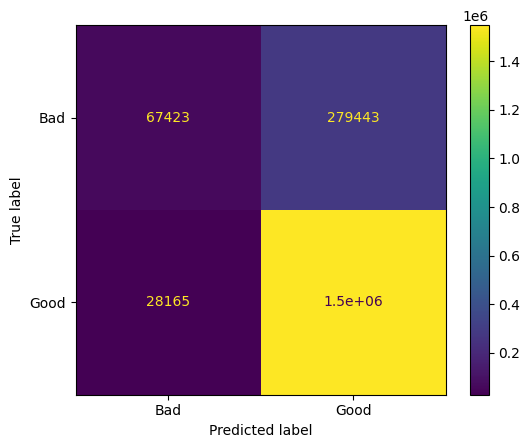

In [27]:
report = TestSVM(elden_ring_svm, elden_ring_vectorizer, steam_X_test, steam_y_test)

### Test elden_ring_svm on game spot data

Testing SVM ...
Tested SVM in 3.0650007724761963 s
Bad: {'precision': 0.7172284644194756, 'recall': 0.3792079207920792, 'f1-score': 0.49611398963730574, 'support': 2020}

Good: {'precision': 0.535899333826795, 'recall': 0.8274285714285714, 'f1-score': 0.6504941599281222, 'support': 1750}

accuracy: 0.5872679045092838

macro avg: {'precision': 0.6265638991231353, 'recall': 0.6033182461103253, 'f1-score': 0.573304074782714, 'support': 3770}

weighted avg: {'precision': 0.6330571173273825, 'recall': 0.5872679045092838, 'f1-score': 0.5677758723982947, 'support': 3770}



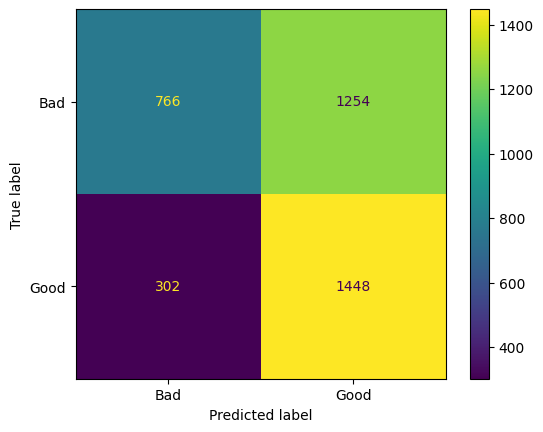

In [28]:
report = TestSVM(elden_ring_svm, elden_ring_vectorizer, game_spot_X_test, game_spot_y_test)

# Train SVM with Steam Data

In [31]:
steam_svm, steam_vectorizer = CreateSVM(steam_X_train, steam_y_train)

training SVM...
Trained SVM in 91.56542897224426 s


### Test steam_svm on steam data

Testing SVM ...
Tested SVM in 81.74524021148682 s
Bad: {'precision': 0.7971666410419732, 'recall': 0.523173213863567, 'f1-score': 0.6317407325534237, 'support': 346866}

Good: {'precision': 0.9024388661331119, 'recall': 0.9707031708516409, 'f1-score': 0.9353271151453015, 'support': 1576075}

accuracy: 0.8899763435279605

macro avg: {'precision': 0.8498027535875425, 'recall': 0.746938192357604, 'f1-score': 0.7835339238493626, 'support': 1922941}

weighted avg: {'precision': 0.8834495390406722, 'recall': 0.8899763435279605, 'f1-score': 0.8805652716024606, 'support': 1922941}



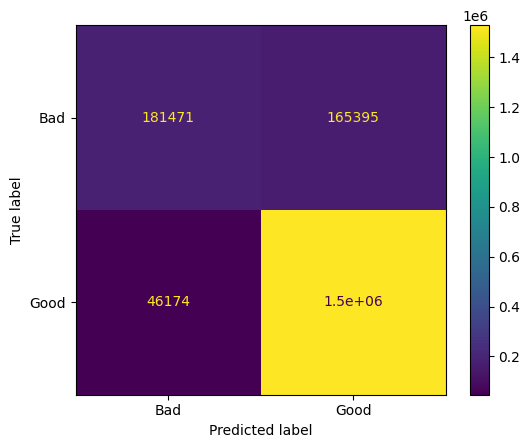

In [32]:
report = TestSVM(steam_svm, steam_vectorizer, steam_X_test, steam_y_test)

### Test steam_svm on game spot data

In [ ]:
report = TestSVM(steam_svm, steam_vectorizer, game_spot_X_test, game_spot_y_test)

Testing SVM ...


### Test steam_svm on elden ring data

In [ ]:
report = TestSVM(steam_svm, steam_vectorizer, elden_ring_X_test, elden_ring_y_test)